# **Customer Churn Prediction**

**Import Library**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
import math
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# feature importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

# helper function
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from imblearn.pipeline import Pipeline
import time

# modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import xgboost

import warnings
warnings.filterwarnings("ignore")

### **Load Data**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [ ]:
file_name = 'Churn_Modelling.csv'
df = pd.read_csv(file_name)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df = df.drop(columns=['HasCrCard'])

Kolom `HasCrCard` didrop karena berdasarkan hasil analisis feature selection memiliki score paling rendah.

# **3. Data Pre-Processing**

### **Missing Value and Duplicated Data**

In [ ]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Dataset tidak
memiliki missing value.

In [ ]:
print(f"Jumlah data duplikat keseluruhan = ", df.duplicated().sum())
print(f"Jumlah data duplikat subset 'RowNumber' = ", df.duplicated(subset=['RowNumber']).sum())
print(f"Jumlah data duplikat subset 'CustomerId' = ", df.duplicated(subset=['CustomerId']).sum())

Jumlah data duplikat keseluruhan =  0
Jumlah data duplikat subset 'RowNumber' =  0
Jumlah data duplikat subset 'CustomerId' =  0


Tidak terdapat data duplikat, sehingga kolom `RowNumber`, `CustomerId`, dan `Surname` akan didrop

In [ ]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


### **Label Encoding**

In [ ]:
cats = ['Geography', 'Gender']
nums = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts', 'IsActiveMember', 'Exited']

In [ ]:
# one hot encoding pada kolom gender dan geography
for cat in cats[:]:
  nominal_encoded = pd.get_dummies(df[cat], prefix=cat)
  df = pd.concat([df, nominal_encoded], axis=1)
for column in df.columns:
  if df[column].dtype == object and column != 'Exited':
    df.drop(column, axis = 1, inplace = True)

In [ ]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,79084.10,0,0,0,1,1,0


### **Train Test Split**

In [ ]:
df_sp = df.copy()

In [ ]:
X = df_sp.drop(['Exited'],axis=1,inplace=False)
y = df_sp['Exited']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.20, random_state=123, stratify = y)

In [ ]:
ytrain.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

### **Handling Outliers**

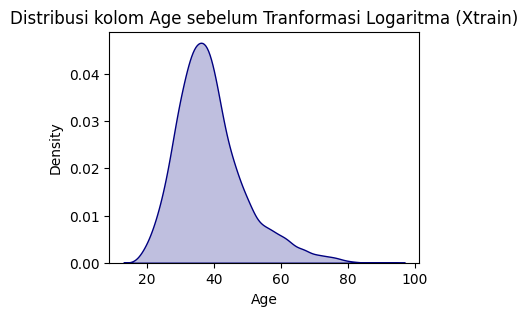

In [ ]:
# distribusi kolom Age pada data Xtrain sebelum dilakukan transformasi logaritma
plt.figure(figsize=(4, 3))
sns.kdeplot(Xtrain['Age'], shade=True, color='navy')
plt.title('Distribusi kolom Age sebelum Tranformasi Logaritma (Xtrain)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

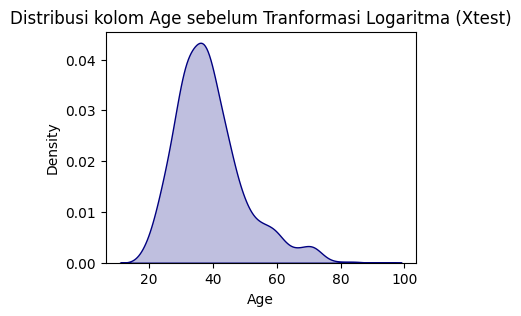

In [ ]:
# distribusi kolom Age pada data Xtest sebelum dilakukan transformasi logaritma
plt.figure(figsize=(4, 3))
sns.kdeplot(Xtest['Age'], shade=True, color='navy')
plt.title('Distribusi kolom Age sebelum Tranformasi Logaritma (Xtest)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In [ ]:
# transformasi logaritma kolom Age pada data Xtrain dan XTest
Xtrain['Age'] = (Xtrain['Age']).apply(np.log)
Xtest['Age'] = (Xtest['Age']).apply(np.log)

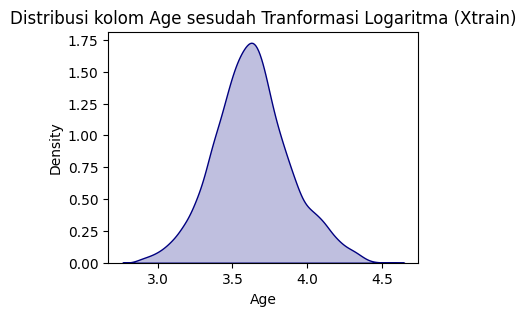

In [ ]:
# distribusi kolom Age pada data XTrain setelah dilakukan transformasi logaritma
plt.figure(figsize=(4, 3))
sns.kdeplot(Xtrain['Age'], shade=True, color='navy')
plt.title('Distribusi kolom Age sesudah Tranformasi Logaritma (Xtrain)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

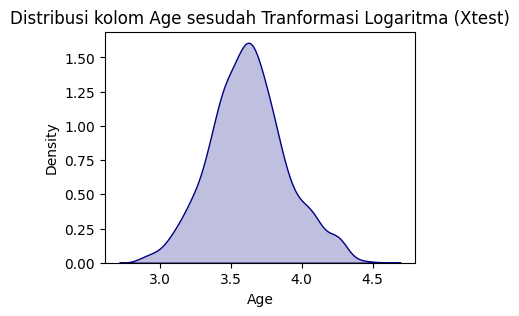

In [ ]:
# distribusi kolom Age pada data Xtest setelah dilakukan transformasi logaritma
plt.figure(figsize=(4, 3))
sns.kdeplot(Xtest['Age'], shade=True, color='navy')
plt.title('Distribusi kolom Age sesudah Tranformasi Logaritma (Xtest)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

## **Feature Transformation**

In [ ]:
numerik = ['CreditScore', 'Balance', 'EstimatedSalary']
features = numerik
num_plots = len(features)
num_cols = 4
num_rows = math.ceil(num_plots / num_cols)

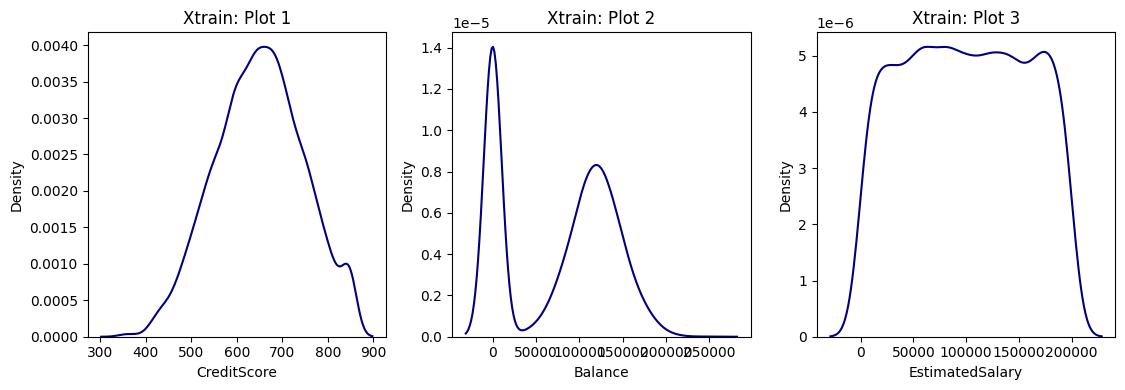

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i+1)
    sns.kdeplot(x=Xtrain[features[i]], color='navy')
    plt.xlabel(features[i])
    plt.title(f'Xtrain: Plot {i+1}')
plt.tight_layout()
plt.show()

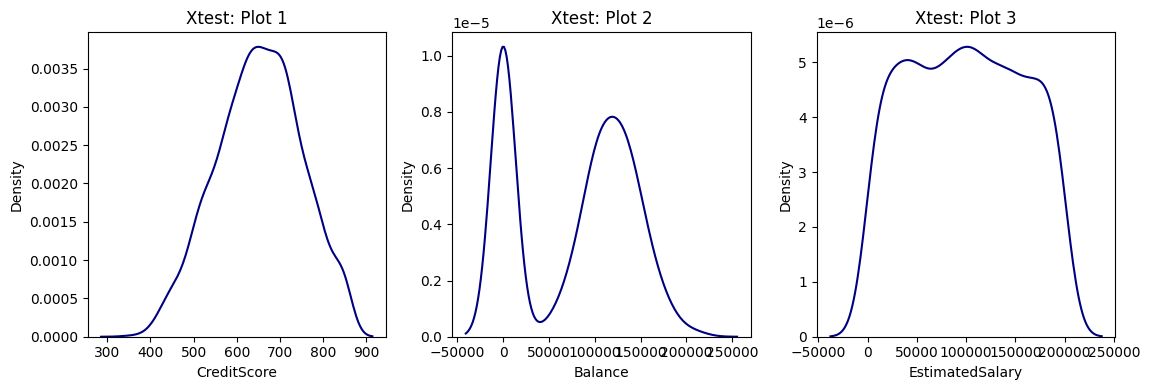

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i+1)
    sns.kdeplot(x=Xtest[features[i]], color='navy')
    plt.xlabel(features[i])
    plt.title(f'Xtest: Plot {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
# fitur transformasi kolom creditscore, balance, dan estimatedsalary pada data xtrain dan xtest
ms = MinMaxScaler()
for col in numerik:
  Xtrain[[col]] = ms.fit_transform(Xtrain[[col]])
  Xtest[[col]] = ms.transform(Xtest[[col]])

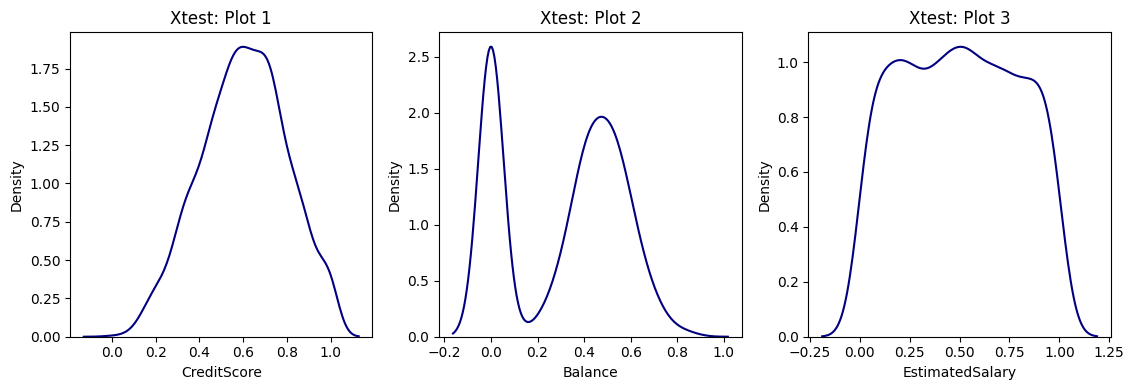

In [ ]:
# distribusi kolom creditscore, balance, dan estimatedsalary pada data Xtest setelah dilakukan transformasi fitur
plt.figure(figsize=(15, 4))
for i in range(num_plots):
    plt.subplot(num_rows, num_cols, i+1)
    sns.kdeplot(x=Xtest[features[i]], color='navy')
    plt.xlabel(features[i])
    plt.title(f'Xtest: Plot {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
Xtrain.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
9385,0.674,3.784190,8,0.380107,2,1,0.008882,0,1,0,0,1
2155,0.620,3.555348,6,0.401632,1,0,0.095949,1,0,0,1,0
768,0.668,3.713572,2,0.477416,2,0,0.601423,0,0,1,0,1
6082,0.750,3.688879,8,0.415107,1,0,0.310111,0,1,0,0,1
2926,0.320,4.143135,8,0.000000,2,1,0.576456,1,0,0,0,1


In [ ]:
Xtest.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
2375,0.930,3.663562,6,0.000000,1,1,0.425822,0,0,1,1,0
2821,0.728,3.496508,10,0.411009,2,1,0.248326,0,0,1,1,0
6969,0.538,3.637586,6,0.000000,2,1,0.588080,0,0,1,1,0
4748,0.374,3.610918,7,0.631380,4,1,0.588451,0,1,0,1,0
76,0.628,4.007333,8,0.000000,2,1,0.695817,1,0,0,0,1


In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9385 to 721
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   float64
 1   Age                8000 non-null   float64
 2   Tenure             8000 non-null   int64  
 3   Balance            8000 non-null   float64
 4   NumOfProducts      8000 non-null   int64  
 5   IsActiveMember     8000 non-null   int64  
 6   EstimatedSalary    8000 non-null   float64
 7   Geography_France   8000 non-null   uint8  
 8   Geography_Germany  8000 non-null   uint8  
 9   Geography_Spain    8000 non-null   uint8  
 10  Gender_Female      8000 non-null   uint8  
 11  Gender_Male        8000 non-null   uint8  
dtypes: float64(4), int64(3), uint8(5)
memory usage: 539.1 KB


In [ ]:
Xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2375 to 719
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        2000 non-null   float64
 1   Age                2000 non-null   float64
 2   Tenure             2000 non-null   int64  
 3   Balance            2000 non-null   float64
 4   NumOfProducts      2000 non-null   int64  
 5   IsActiveMember     2000 non-null   int64  
 6   EstimatedSalary    2000 non-null   float64
 7   Geography_France   2000 non-null   uint8  
 8   Geography_Germany  2000 non-null   uint8  
 9   Geography_Spain    2000 non-null   uint8  
 10  Gender_Female      2000 non-null   uint8  
 11  Gender_Male        2000 non-null   uint8  
dtypes: float64(4), int64(3), uint8(5)
memory usage: 134.8 KB


## **Handling Imbalanced Data**

In [ ]:
ytrain.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

In [ ]:
smote = SMOTE(sampling_strategy=1, random_state=123)
Xtrain_over, ytrain_over = smote.fit_resample(Xtrain, ytrain)

print('SMOTE')
print(pd.Series(ytrain_over).value_counts())

SMOTE
0    6370
1    6370
Name: Exited, dtype: int64


Dilakukan oversampling karena data yang dimiliki berjumlah sedikit

## **Feature Selection**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   IsActiveMember     10000 non-null  int64  
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  int64  
 8   Geography_France   10000 non-null  uint8  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Female      10000 non-null  uint8  
 12  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(6), uint8(5)
memory usage: 674.0 KB


<Axes: >

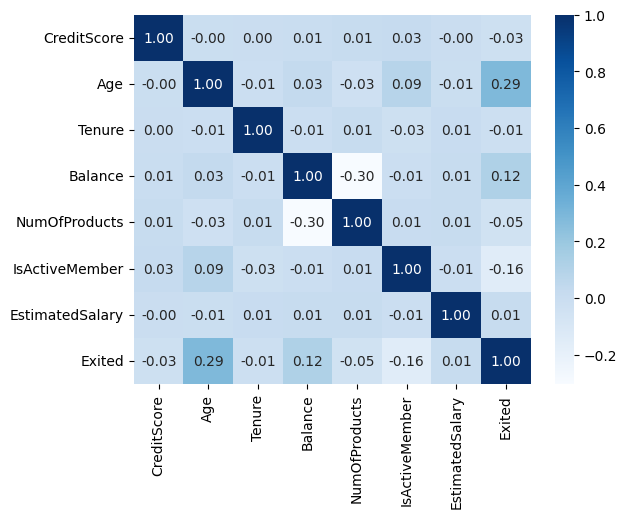

In [ ]:
# Membuat heatmap
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), cmap='Blues', annot=True, fmt='.2f')

- Tidak ada multikolinearitas antar fitur (tidak ada fitur
redundan)
- Berdasarkan linear corelation, fitur `HasCrCard`, `Tenure`, `EstimatedSalary` memiliki skor paling rendah terhadap fitur target
- Diperlukan analisis fitur lebih lanjut karena heatmap corr hanya melihat hubungan linear corr. Sedangkan, fitur yang ada merupakan campuran numerik dan kategorik

**Mutual Information Classification**

In [ ]:
X = df.drop(columns=['Exited'])
y= df['Exited']

mi_scores = mutual_info_classif(X, y,random_state=123)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

Age                  0.069581
NumOfProducts        0.065374
IsActiveMember       0.015766
Geography_France     0.014801
Geography_Germany    0.014396
Gender_Male          0.010582
Geography_Spain      0.008577
Balance              0.007875
CreditScore          0.006393
Gender_Female        0.003311
EstimatedSalary      0.002704
HasCrCard            0.001863
Tenure               0.000853
Name: MI Scores, dtype: float64


**Chi_square Test**

In [ ]:
X = df.drop(columns=['Exited'])
y= df['Exited']

chi2_stats, p_values = chi2(X, y)
chi2_stats = pd.Series(chi2_stats, name="Chi2 Scores", index=X.columns)
chi2_stats = chi2_stats.sort_values(ascending=False)
print(chi2_stats)

Balance              7.151303e+06
EstimatedSalary      4.835088e+04
Age                  2.300417e+03
Geography_Germany    2.254644e+02
IsActiveMember       1.181994e+02
CreditScore          1.054035e+02
Gender_Female        6.190917e+01
Geography_France     5.492371e+01
Gender_Male          5.153993e+01
Geography_Spain      2.086721e+01
NumOfProducts        5.055394e+00
Tenure               3.270538e+00
HasCrCard            1.500410e-01
Name: Chi2 Scores, dtype: float64


In [ ]:
p_values = pd.Series(p_values, name="p_value", index=X.columns)
p_values = p_values.sort_values(ascending=False)
print(p_values)

HasCrCard            6.984962e-01
Tenure               7.053449e-02
NumOfProducts        2.454940e-02
Geography_Spain      4.922505e-06
Gender_Male          7.015575e-13
Geography_France     1.253006e-13
Gender_Female        3.596700e-15
CreditScore          9.963536e-25
IsActiveMember       1.568036e-27
Geography_Germany    5.814572e-51
Age                  0.000000e+00
Balance              0.000000e+00
EstimatedSalary      0.000000e+00
Name: p_value, dtype: float64


**ANOVA**

In [ ]:
X = df.drop(columns=['Exited'])
y= df['Exited']

f_statistic, p_values = f_classif(X, y)
f_statistic = pd.Series(f_statistic, name="f Scores", index=X.columns)
f_statistic = f_statistic.sort_values(ascending=False)
print(f_statistic)

Age                  886.063275
Geography_Germany    310.258384
IsActiveMember       249.800794
Balance              142.473832
Gender_Female        114.727989
Gender_Male          114.727989
Geography_France     111.360517
Geography_Spain       27.809468
NumOfProducts         22.915223
CreditScore            7.344522
Tenure                 1.960164
EstimatedSalary        1.463262
HasCrCard              0.509401
Name: f Scores, dtype: float64


In [ ]:
p_values = pd.Series(p_values, name="p_value", index=X.columns)
p_values = p_values.sort_values(ascending=False)
print(p_values)

HasCrCard             4.754149e-01
EstimatedSalary       2.264404e-01
Tenure                1.615268e-01
CreditScore           6.738214e-03
NumOfProducts         1.717333e-06
Geography_Spain       1.366655e-07
Geography_France      6.748446e-26
Gender_Male           1.258505e-26
Gender_Female         1.258505e-26
Balance               1.275563e-32
IsActiveMember        1.348269e-55
Geography_Germany     2.059537e-68
Age                  1.239931e-186
Name: p_value, dtype: float64


**Feature Importance**

In [ ]:
# Inisialisasi model
lr = LogisticRegression()

# Fit model
X = df.drop(columns=['Exited'])
Y = df['Exited']
lr.fit(X, Y)

# Mendapatkan koefisien dan nama kolom
coef_list = lr.coef_[0]
col_names = X.columns

# Menggabungkan nama kolom dan koefisien
coef_names = list(zip(col_names, coef_list))

# Mengurutkan berdasarkan nilai koefisien
coef_names_sorted = sorted(coef_names, key=lambda x: abs(x[1]), reverse=True)

# Menampilkan koefisien model
for coef_name in coef_names_sorted:
    print(f"{coef_name[0]}: {coef_name[1]}")

Age: 0.043807546576597085
CreditScore: -0.005035182089427734
Tenure: -0.0015910377834282702
IsActiveMember: -0.0014176858321061478
Gender_Male: -0.0010387251247863873
Geography_Germany: 0.0009484549902202534
Gender_Female: 0.0008464520292677897
Geography_France: -0.0008062849264256583
NumOfProducts: -0.00044596539619593233
Geography_Spain: -0.0003344431593162576
HasCrCard: -0.00018679235992356466
Balance: 3.621667904540886e-06
EstimatedSalary: -1.3615427356296452e-06


# **4. Modeling**

##### **Helper Function**

In [ ]:
def eval_classification(model, smote=True):
    y_pred = model.predict(Xtest)
    y_pred_train = model.predict(Xtrain)
    y_pred_proba = model.predict_proba(Xtest)
    y_pred_proba_train = model.predict_proba(Xtrain)

    model1 = Pipeline([
        ('sampling', SMOTE(sampling_strategy=1, random_state=123)),
        ('classification', model)
    ])

    print("Accuracy (Train): %.2f" % accuracy_score(ytrain, y_pred_train))
    print("Accuracy (Test): %.2f" % accuracy_score(ytest, y_pred))

    print("Precision (Train): %.2f" % precision_score(ytrain, y_pred_train))
    print("Precision (Test): %.2f" % precision_score(ytest, y_pred))

    print("Recall (Train): %.2f" % recall_score(ytrain, y_pred_train))
    print("Recall (Test): %.2f" % recall_score(ytest, y_pred))

    print("F1-Score (Test): %.2f" % f1_score(ytest, y_pred))

    print("roc_auc (train-proba): %.2f" % roc_auc_score(ytrain, y_pred_proba_train[:, 1]))
    print("roc_auc (test-proba): %.2f" % roc_auc_score(ytest, y_pred_proba[:, 1]))

    if smote==True:
      cv = RepeatedStratifiedKFold(random_state=123, n_repeats = 3)
      score = cross_validate(model1, X=Xtrain, y=ytrain, cv=cv, scoring='roc_auc', return_train_score=True)
      print("roc_auc (crossval train): " + str(score['train_score'].mean()))
      print("roc_auc (crossval test): " + str(score['test_score'].mean()))


def grid_pipe(pipedict, hyperdict, scoring='recall', display=True):
    fitted_models={}
    for name, pipeline in pipedict.items():
        # membangun grid search
        model = GridSearchCV(estimator= pipeline,
                             param_grid= hyperdict[name],
                             scoring= scoring,
                             cv= 5, verbose= 2, n_jobs= -1,
                             return_train_score = True)

        # fit menggunakan grid search
        start = time.time()
        model.fit(Xtrain, ytrain)
        end = time.time()

        # menambahkan model
        fitted_models[name]=model
        if display:
            print(f'The {name} model has been fitted.') # print ketika model telah fit
            print('Total Fit Time: %.3fs' % (end-start)) # print fit time
            print('Best params:\n', model.best_params_,'\n') # print parameter terbaik

    return fitted_models

def confusion(model):
    y_pred_proba = model.predict_proba(Xtest)
    y_predict = model.predict(Xtest)
    print('Accuracy: %.2f%%' % (accuracy_score(ytest, y_predict) * 100 ))
    print('Precision: %.2f%%' % (precision_score(ytest, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(ytest, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(ytest, y_predict) * 100))
    print('ROC_AUC: %.2f%%' % (roc_auc_score(ytest, y_pred_proba[:,1]) * 100))
    confusion_matrix_model = confusion_matrix(ytest, y_predict)

    plt.figure(figsize=(12,8))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

##### **Fit Model**

Metrics evaluasi akan berfokus pada  *Recall* untuk mengurangi False Negative rate sebanyak-banyaknya. Digunakan 4 model untuk modelling yaitu Logistic Regression, Decision Tree, Adaboost, KNN, Random Forest, dan XGBoost.

**Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg.fit(Xtrain_over, ytrain_over)

eval_classification(logreg)

Accuracy (Train): 0.71
Accuracy (Test): 0.70
Precision (Train): 0.39
Precision (Test): 0.36
Recall (Train): 0.70
Recall (Test): 0.66
F1-Score (Test): 0.47
roc_auc (train-proba): 0.77
roc_auc (test-proba): 0.76
roc_auc (crossval train): 0.7729876453884998
roc_auc (crossval test): 0.7709690105395627


**Decision Tree**

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(Xtrain_over, ytrain_over)

eval_classification(dt)

Accuracy (Train): 1.00
Accuracy (Test): 0.78
Precision (Train): 1.00
Precision (Test): 0.46
Recall (Train): 1.00
Recall (Test): 0.60
F1-Score (Test): 0.52
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.71
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.6940083725798012


**AdaBoost**

In [ ]:
ada = AdaBoostClassifier()
ada.fit(Xtrain_over, ytrain_over)

eval_classification(ada)

Accuracy (Train): 0.79
Accuracy (Test): 0.80
Precision (Train): 0.49
Precision (Test): 0.51
Recall (Train): 0.72
Recall (Test): 0.75
F1-Score (Test): 0.61
roc_auc (train-proba): 0.85
roc_auc (test-proba): 0.86
roc_auc (crossval train): 0.8486464382827223
roc_auc (crossval test): 0.838134083269929


**KNN**

In [ ]:
knn = KNeighborsClassifier()
knn.fit(Xtrain_over, ytrain_over)

eval_classification(knn)

Accuracy (Train): 0.84
Accuracy (Test): 0.73
Precision (Train): 0.57
Precision (Test): 0.40
Recall (Train): 0.92
Recall (Test): 0.67
F1-Score (Test): 0.50
roc_auc (train-proba): 0.95
roc_auc (test-proba): 0.76
roc_auc (crossval train): 0.9514252126050987
roc_auc (crossval test): 0.7495008716086718


**Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state = 123)
rf.fit(Xtrain_over, ytrain_over)

eval_classification(rf)

Accuracy (Train): 1.00
Accuracy (Test): 0.84
Precision (Train): 1.00
Precision (Test): 0.59
Recall (Train): 1.00
Recall (Test): 0.65
F1-Score (Test): 0.62
roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.85
roc_auc (crossval train): 1.0
roc_auc (crossval test): 0.8453486113652635


**XGBoost**

In [ ]:
xg = XGBClassifier()
xg.fit(Xtrain_over, ytrain_over)

eval_classification(xg)

Accuracy (Train): 0.95
Accuracy (Test): 0.85
Precision (Train): 0.89
Precision (Test): 0.64
Recall (Train): 0.84
Recall (Test): 0.57
F1-Score (Test): 0.60
roc_auc (train-proba): 0.98
roc_auc (test-proba): 0.85
roc_auc (crossval train): 0.9856458150744961
roc_auc (crossval test): 0.8368253861242467


Berdasarkan nilai cross validation, beberapa model masih overfitting dan belum dapat men-generalisir dengan baik, sehingga akan dilakukan Hyperparameter Tuning untuk mengurangi overfitting.

##### **Hyperparameter Tuning**

In [ ]:
# membuat alur untuk setiap classifiers
pipelines = {'logisticregression': Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', LogisticRegression())]),
             'decisiontree'      : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', DecisionTreeClassifier())]),
             'adaboost'          : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', AdaBoostClassifier())]),
             'knn'               : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', KNeighborsClassifier())]),
             'randomforest'      : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', RandomForestClassifier(random_state = 123))]),
             'xgboost'           : Pipeline([('sampling', SMOTE(sampling_strategy=1, random_state=123)),
                                             ('clf', XGBClassifier(nthread=6, tree_method='hist',  predictor='cpu_predictor'))])}

# menentukan Hyperparameters untuk setiap pipeline
hyperparameters_lr = {'clf__C': [0.1, 0.2, 0.3]}

hyperparameters_dt = {'clf__max_depth'        : [1, 3, 5], # kedalaman maksimum pohon
                      'clf__min_samples_split': [1, 2, 5], # jumlah sampel minimum yang diperlukan untuk memisahkan sebuah node
                      'clf__min_samples_leaf' : [0.5, 1, 2], # jumlah minimum sampel yang diperlukan di setiap leaf node
                      'clf__criterion'        : ['gini','entropy']} # mengukur kualitas pemisahan

hyperparameters_ada = {'clf__learning_rate' : [0.27, 0.29, 0.31], # laju pembelajaran untuk mengontrol setiap estimator
                      'clf__n_estimators'   : [37, 38, 39], # jumlah estimator dalam ensemble
                      'clf__algorithm'      : ['SAMME', 'SAMME.R']}

hyperparameters_knn = {'clf__n_neighbors': [13, 15, 17], # jumlah tetangga
                       'clf__weights'    : ['uniform', 'distance'], # bobot tetangga
                       'clf__leaf_size'  : [0.05, 1, 3], # ukuran leaf dalam poho
                       'clf__algorithm'  : ['auto']} # algoritma untuk menghitung tetangga terdekat

hyperparameters_rf = {'clf__n_estimators'     : [100, 110, 120], # jumlah pohon dalam ensemble
                      'clf__criterion'        : ['entropy', 'gini'], # kriteria untuk membuat pohon
                      'clf__max_features'     : ['auto'], # fitur untuk mencari pemisahan terbaik
                      'clf__min_samples_leaf' : [0.1, 0.2, 0.3]} # jumlah minimum sampel

hyperparameters_xgb = {'clf__eta'             : [0.20, 0.30, 0.40],
                       'clf__max_depth'       : [2], # kedalaman maksimum setiap pohon dalam ensemble
                       'clf__scale_pos_weight': [2]}

# inisiasi hyperparameter
hyperparameters = {'logisticregression':hyperparameters_lr,
                   'decisiontree': hyperparameters_dt,
                   'adaboost': hyperparameters_ada,
                   'knn': hyperparameters_knn,
                   'randomforest':hyperparameters_rf,
                   'xgboost': hyperparameters_xgb}

In [ ]:
fitted_models = grid_pipe(pipelines, hyperparameters, scoring='recall')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
The logisticregression model has been fitted.
Total Fit Time: 3.590s
Best params:
 {'clf__C': 0.2} 

Fitting 5 folds for each of 54 candidates, totalling 270 fits
The decisiontree model has been fitted.
Total Fit Time: 11.642s
Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The adaboost model has been fitted.
Total Fit Time: 43.923s
Best params:
 {'clf__algorithm': 'SAMME.R', 'clf__learning_rate': 0.29, 'clf__n_estimators': 38} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The knn model has been fitted.
Total Fit Time: 73.883s
Best params:
 {'clf__algorithm': 'auto', 'clf__leaf_size': 1, 'clf__n_neighbors': 15, 'clf__weights': 'uniform'} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The randomforest model has been fitted.
Total Fit Time: 44.311s
Best params:


##### **Result After Hyperparameter Tuning**

**Logistic Regression**

In [ ]:
logreg = LogisticRegression(C=0.2)
logreg.fit(Xtrain_over, ytrain_over)

eval_classification(logreg)

Accuracy (Train): 0.71
Accuracy (Test): 0.70
Precision (Train): 0.39
Precision (Test): 0.36
Recall (Train): 0.70
Recall (Test): 0.65
F1-Score (Test): 0.47
roc_auc (train-proba): 0.77
roc_auc (test-proba): 0.76
roc_auc (crossval train): 0.7729380054286935
roc_auc (crossval test): 0.770874465878848


**Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf= 1, min_samples_split= 2)
dt.fit(Xtrain_over, ytrain_over)

eval_classification(dt)

Accuracy (Train): 0.79
Accuracy (Test): 0.79
Precision (Train): 0.48
Precision (Test): 0.48
Recall (Train): 0.65
Recall (Test): 0.66
F1-Score (Test): 0.56
roc_auc (train-proba): 0.81
roc_auc (test-proba): 0.81
roc_auc (crossval train): 0.7953899495735057
roc_auc (crossval test): 0.7902749018437011


**Adaboost**

In [ ]:
ada = AdaBoostClassifier(algorithm = 'SAMME.R', learning_rate= 0.29, n_estimators= 38)
ada.fit(Xtrain_over, ytrain_over)
eval_classification(ada)

Accuracy (Train): 0.79
Accuracy (Test): 0.79
Precision (Train): 0.48
Precision (Test): 0.49
Recall (Train): 0.73
Recall (Test): 0.76
F1-Score (Test): 0.60
roc_auc (train-proba): 0.84
roc_auc (test-proba): 0.86
roc_auc (crossval train): 0.8436980325400572
roc_auc (crossval test): 0.839381864118937


**KNN**

In [ ]:
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size = 1, n_neighbors = 15, weights = 'uniform')
knn.fit(Xtrain_over, ytrain_over)

eval_classification(knn)

Accuracy (Train): 0.78
Accuracy (Test): 0.72
Precision (Train): 0.47
Precision (Test): 0.39
Recall (Train): 0.81
Recall (Test): 0.67
F1-Score (Test): 0.50
roc_auc (train-proba): 0.88
roc_auc (test-proba): 0.77
roc_auc (crossval train): 0.8778059117700879
roc_auc (crossval test): 0.7701093604029625


**Random Forest**

In [ ]:
rf = RandomForestClassifier(criterion='gini', max_features='auto', min_samples_leaf=0.2, n_estimators = 110, random_state=123)
rf.fit(Xtrain_over, ytrain_over)

eval_classification(rf)

Accuracy (Train): 0.73
Accuracy (Test): 0.73
Precision (Train): 0.41
Precision (Test): 0.40
Recall (Train): 0.68
Recall (Test): 0.66
F1-Score (Test): 0.50
roc_auc (train-proba): 0.78
roc_auc (test-proba): 0.77
roc_auc (crossval train): 0.7812559090412946
roc_auc (crossval test): 0.7794366968118062


**XGBoost**

In [ ]:
xg = XGBClassifier(eta = 0.2, max_depth = 2, scale_pos_weight = 2, nthread=6, tree_method='hist',  predictor='cpu_predictor')
xg.fit(Xtrain_over, ytrain_over)

eval_classification(xg)

Accuracy (Train): 0.74
Accuracy (Test): 0.74
Precision (Train): 0.43
Precision (Test): 0.43
Recall (Train): 0.85
Recall (Test): 0.85
F1-Score (Test): 0.57
roc_auc (train-proba): 0.87
roc_auc (test-proba): 0.87
roc_auc (crossval train): 0.8733395744446907
roc_auc (crossval test): 0.8583423222993773




*   Nilai cross validation sudah lebih baik sehingga semua model sudah best fit dan tidak overfitting.
*   Hyperparameter yang digunakan diatur sedemikian rupa agar tidak overfitting, tidak memakan waktu yang cukup lama, dan dapat menghasilkan nilai recall tertinggi tanpa mengorbankan nilai accuracy dan precision yang begitu besar.
*   Model yang dipilih adalah XGBoost karena memiliki nilai recall yang tertinggi.






**Confusion Matrix XGBoost**

Accuracy: 74.15%
Precision: 43.12%
Recall: 84.77%
F1_Score: 57.17%
ROC_AUC: 86.74%


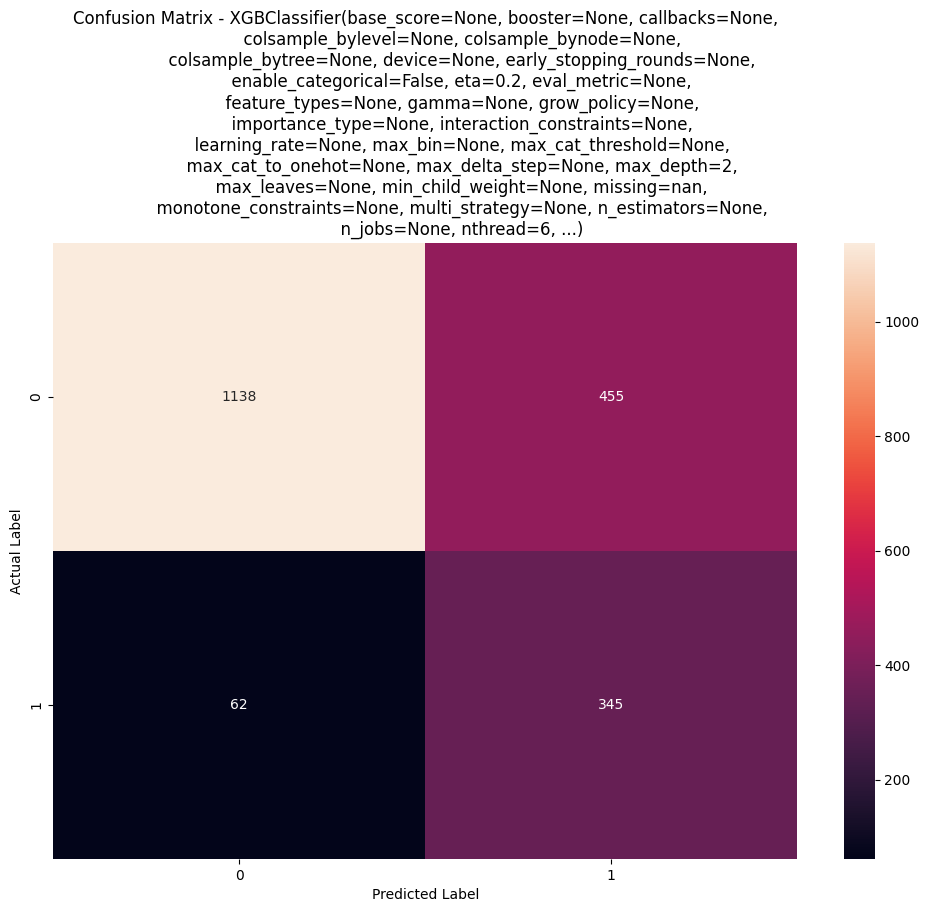

In [ ]:
confusion(xg)

##### **Feature Importance**

In [ ]:
# Mengeluarkan feature importance
feature_importance = xg.feature_importances_

# Menyusun hasil feature importance ke dalam DataFrame (opsional)
feature_importance_df = pd.DataFrame({
    'Feature': Xtrain_over.columns,
    'Importance': feature_importance
})

# Menampilkan feature importance secara terurut menurun
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

              Feature  Importance
4       NumOfProducts    0.206583
1                 Age    0.194538
5      IsActiveMember    0.145326
3             Balance    0.103831
8   Geography_Germany    0.103785
11        Gender_Male    0.076619
10      Gender_Female    0.052391
6     EstimatedSalary    0.026416
9     Geography_Spain    0.025565
2              Tenure    0.024625
0         CreditScore    0.021942
7    Geography_France    0.018377


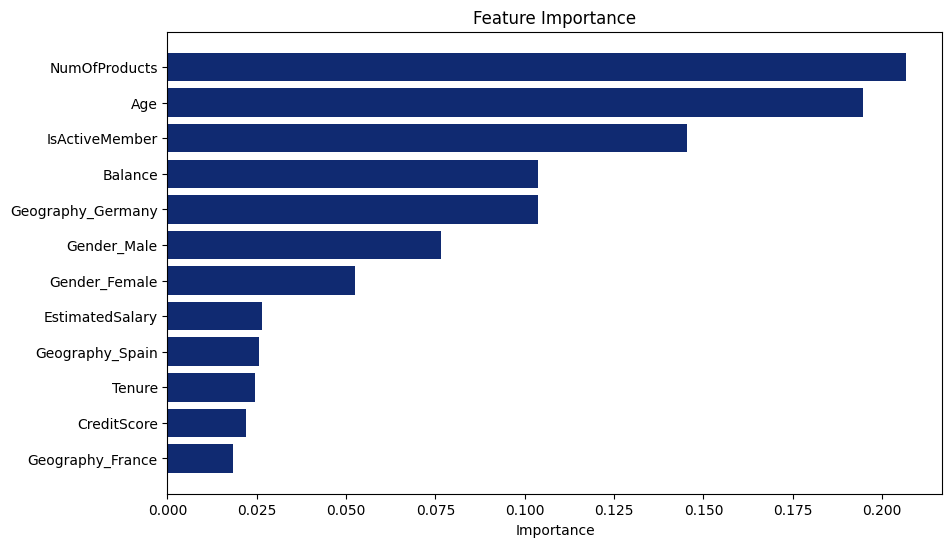

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
# Membuat bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#102A71')
plt.xlabel('Importance')
plt.title('Feature Importance')

plt.grid(False)
plt.show()

##### **Shap Value**

In [ ]:
pip install shap xgboost

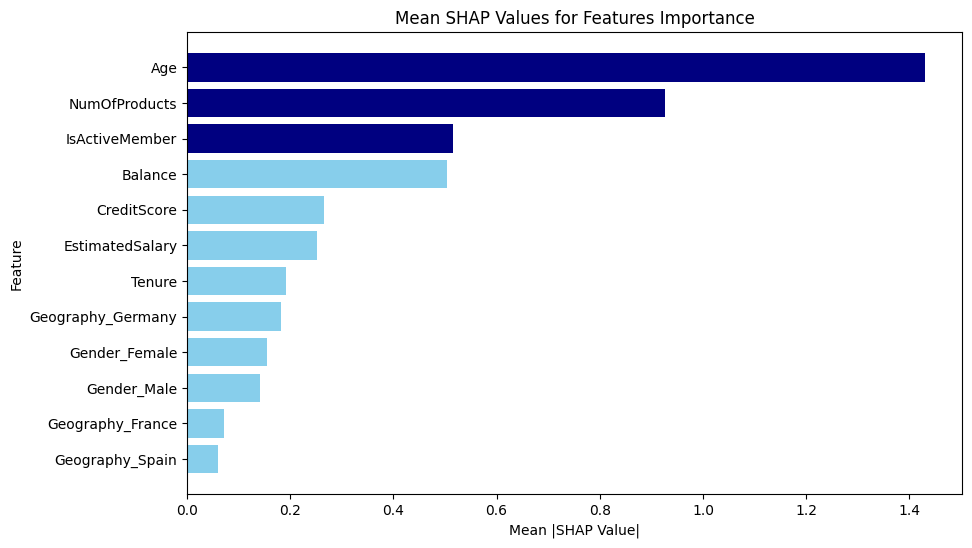

In [ ]:
# Latih model XGBoost
model = xgboost.XGBClassifier()
model.fit(Xtrain_over, ytrain_over)

# Hitung SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest)

# Hitung mean SHAP values
mean_shap_values = abs(shap_values).mean(axis=0)

# Mengurutkan fitur berdasarkan nilai SHAP yang terkecil
sorted_indices = mean_shap_values.argsort()
sorted_mean_shap_values = mean_shap_values[sorted_indices]
sorted_features = Xtest.columns[sorted_indices]

# Plot bar SHAP dengan matplotlib
plt.figure(figsize=(10, 6))

# Plot barplot dengan warna merah untuk tiga fitur terbesar
color_map = ['skyblue'] * len(Xtest.columns)
color_map[-3:] = ['navy'] * 3  # Ubah warna tiga fitur terbesar menjadi merah

plt.barh(sorted_features, sorted_mean_shap_values, color=color_map)
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Features Importance')
plt.show()

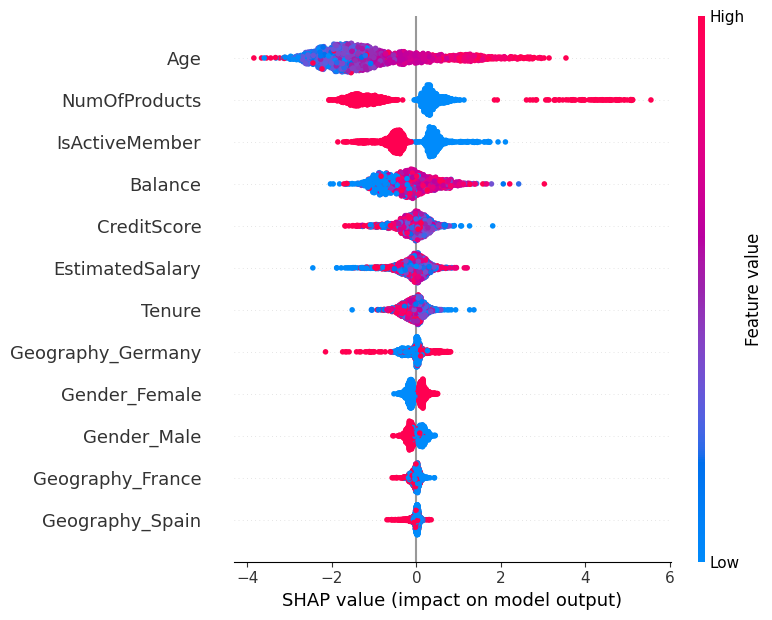

In [ ]:
model = xgboost.XGBClassifier()
model.fit(Xtrain_over, ytrain_over)

# Hitung SHAP values
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(Xtest)

# Buat plot bar SHAP
shap.summary_plot(shap_values, Xtest)